In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from datetime import datetime

from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
from scipy.io import loadmat


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from src import SMOTE
from src import CFS
from src import metrices_V2 as metrices

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
def apply_smote(df):
    df.reset_index(drop=True,inplace=True)
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def apply_cfs(df):
        y = df.Bugs.values
        X = df.drop(labels = ['Bugs'],axis = 1)
        X = X.values
        selected_cols = CFS.cfs(X,y)
        cols = df.columns[[selected_cols]].tolist()
        cols.append('Bugs')
        return df[cols],cols

In [3]:
def load_data_commit_level(project,metric):
    data_path = 'data/merged_data/' + project + '.csv'
    data_df = pd.read_csv(data_path)
    data_df.rename(columns = {'Unnamed: 0':'id'},inplace = True)
    data_df = data_df.drop(labels = ['id'],axis=1)
    
    y = data_df.Bugs
    commit_hash = data_df.commit_hash
    X = data_df.drop(['Bugs','commit_hash'],axis = 1)
    
    
    if metric == 'process':
        X = X[['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr','release']]
    elif metric == 'product':
        X = X.drop(['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr'],axis = 1)
    else:
        X = X
    
    df = X
    df['commit_hash'] = commit_hash
    df['Bugs'] = y
    
    return df

In [4]:
def run_cross_release(project,test_projects,metric):
    precision = []
    recall = []
    pf = []
    f1 = []
    g_score = []
    auc = []
    pci_20 = []
    ifa = []
    train_probability = []
    predicted_probability = []
    test_probability = []
    train_df = load_data_commit_level(project,metric)
    
    train_df = train_df.drop('commit_hash',axis = 1)
    train_df = train_df.drop('release',axis = 1)
    y = train_df.Bugs.values.tolist()
    X = train_df.drop('Bugs',axis = 1)
    df_smote = X
    df_smote['Bugs'] = y
    df_smote = apply_smote(df_smote)
    y_train = df_smote.Bugs
    X_train = df_smote.drop('Bugs',axis = 1)
    clf =  RandomForestClassifier()
    clf.fit(X_train,y_train)
    importance = clf.feature_importances_
    count = 0
    for test_project in test_projects:
        try:
            count += 1
            test_df = load_data_commit_level(test_project,metric)
            for release in test_df.release.unique():
                test_df_subset = test_df[test_df['release'] == release]
                test_df_subset = test_df_subset.drop('release',axis = 1)
                y_test = test_df_subset.Bugs
                X_test = test_df_subset.drop(['Bugs','commit_hash'],axis = 1)
                if metric == 'process':
                    loc = X_test['file_la'] + X_test['file_lt']
                elif metric == 'product':
                    loc = X_test.CountLineCode
                else:
                    loc = X_test['file_la'] + X_test['file_lt']                 
                predicted = clf.predict(X_test)
                abcd = metrices.measures(y_test,predicted,loc)
                pf.append(abcd.get_pf())
                recall.append(abcd.calculate_recall())
                precision.append(abcd.calculate_precision())
                f1.append(abcd.calculate_f1_score())
                g_score.append(abcd.get_g_score())
                pci_20.append(abcd.get_pci_20())
                ifa.append(abcd.get_ifa())
                try:
                    auc.append(roc_auc_score(y_test, predicted))
                except:
                    auc.append(0)
                train_probability.append(y.count(1)/len(y))

                y_test = y_test.values.tolist()
                predicted = list(predicted)

                predicted_probability.append(predicted.count(1)/len(predicted))
                test_probability.append(y_test.count(1)/len(y_test))
#                 print(classification_report(y_test, predicted))
        except Exception as e:
            print(e,test_project)
            continue
#         print(recall,precision,pf,f1,g_score,auc,pci_20)
        print(round(count/len(test_projects),2))
    return recall,precision,pf,f1,g_score,auc,pci_20,ifa,importance,train_probability,predicted_probability,test_probability

In [5]:
proj_df = pd.read_csv('projects.csv')
projects = proj_df.repo_name.tolist()

In [6]:
precision_list = {}
recall_list = {}
pf_list = {}
f1_list = {}
g_list = {}
auc_list = {}
pci_20_list = {}
ifa_list = {}
featue_importance = {}
train_probabilities = {}
predicted_probabilities = {}
test_probabilities = {}
count = 0
for project in projects:
    try:
        count += 1
        if project == '.DS_Store':
            continue
        print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
        start_time = time.time()
        recall,precision,pf,f1,g_score,auc,pci_20,ifa,importance,train_probability,predicted_probability,test_probability = run_cross_release(project,projects,'process+product')
        print("--- %s seconds ---" % (time.time() - start_time))
        if recall == 0 and precision == 0 and pf == 0:
            continue
        recall_list[project] = recall
        precision_list[project] = precision
        pf_list[project] = pf
        f1_list[project] = f1
        g_list[project] = g_score
        auc_list[project] = auc
        pci_20_list[project] = pci_20
        ifa_list[project] = ifa
        featue_importance[project] = importance
        train_probabilities[project] = train_probability
        predicted_probabilities[project] = predicted_probability
        test_probabilities[project] = test_probability
        print(round(count/len(projects),2))
    except Exception as e:
        print(e)
        continue
final_result = {}
final_result['precision'] = precision_list
final_result['recall'] = recall_list
final_result['pf'] = pf_list
final_result['f1'] = f1_list
final_result['g'] = g_list
final_result['auc'] = auc_list
final_result['pci_20'] = pci_20_list
final_result['ifa'] = ifa_list
final_result['featue_importance'] = featue_importance
final_result['train_probability'] = train_probabilities
final_result['predicted_probability'] = predicted_probabilities
final_result['test_probability'] = test_probabilities


+++++++++++++++++   600SeriesAndroidUploader  +++++++++++++++++
[Errno 2] File data/merged_data/600SeriesAndroidUploader.csv does not exist: 'data/merged_data/600SeriesAndroidUploader.csv'
+++++++++++++++++   ActionBarSherlock  +++++++++++++++++
[Errno 2] File data/merged_data/ActionBarSherlock.csv does not exist: 'data/merged_data/ActionBarSherlock.csv'
+++++++++++++++++   addressbook-level3  +++++++++++++++++
[Errno 2] File data/merged_data/addressbook-level3.csv does not exist: 'data/merged_data/addressbook-level3.csv'
+++++++++++++++++   addressbook-level4  +++++++++++++++++
[Errno 2] File data/merged_data/addressbook-level4.csv does not exist: 'data/merged_data/addressbook-level4.csv'
+++++++++++++++++   aem-core-wcm-components  +++++++++++++++++
[Errno 2] File data/merged_data/aem-core-wcm-components.csv does not exist: 'data/merged_data/aem-core-wcm-components.csv'
+++++++++++++++++   ahbottomnavigation  +++++++++++++++++
[Errno 2] File data/merged_data/ahbottomnavigation.csv do

In [541]:
for goal in final_result.keys():
    score = []
    for project in final_result[goal].keys():
        score.append(np.nanmedian(final_result[goal][project]))
    print(goal, ":", np.nanmedian(score))

precision : 0.98
recall : 1.0
pf : 0.0
f1 : 0.96
g : 0.99
auc : 0.9666666666666667
pci_20 : 0.57
ifa : 0.0
featue_importance : 0.002892998802960537
train_probability : 0.39729299363057324
predicted_probability : 0.32
test_probability : 0.3076923076923077


In [542]:
with open('results/Performance/commit_guru_file_specific/process_700_rf_release_devanvu_set4.pkl', 'wb') as handle:
    pickle.dump(final_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [538]:
final_result['test_probability']

{'plantuml': [0.19487179487179487, 0.0, 0.010121457489878543]}

In [529]:
with open('results/Performance/commit_guru_file_specific/process_700_rf_release_devanvu_set3.pkl', 'rb') as handle:
    final_result = pickle.load(handle)
    for goal in final_result.keys():
        score = []
        for project in final_result[goal].keys():
            score.append(final_result[goal][project][0])
        print(goal, ":", np.nanmedian(score))

precision : 1.0
recall : 1.0
pf : 0.0
f1 : 0.98
g : 1.0
auc : 0.9705882352941176
pci_20 : 0.5
ifa : 0.0
featue_importance : 0.017081527428294097


# Compare Performance of process, product for release level prediction (RQ1)

In [424]:
dfs = ['process','product','process+product']
final_df = pd.DataFrame()
metrics = ['precision', 'recall', 'pf', 'auc', 'pci_20','ifa']
i = 0
for metric in metrics:
    data = []
    for df in dfs:
        file = pd.read_pickle('results/Performance/commit_guru_file_specific/' + df +'_700_rf_release_devanvu_set3.pkl')
        if metric == 'ifa':
            l = [np.nanmedian(sublist)/100 for sublist in list(file[metric].values())]
        else:
            l = [np.nanmedian(sublist) for sublist in list(file[metric].values())]
#         print(metric,df,np.nanmedian(l))
        data.append(l)
    data_df = pd.DataFrame(data)
    data_df.index = [['P','C','P+C']]
    x = pd.melt(data_df.T)
    x.columns = ['Metric Type','Score']
    if metric == 'pci_20':
        metric = 'popt_20'
    x['Evaluation Criteria'] = [metric]*x.shape[0]
    final_df = pd.concat([final_df,x])
final_df.columns = x.columns

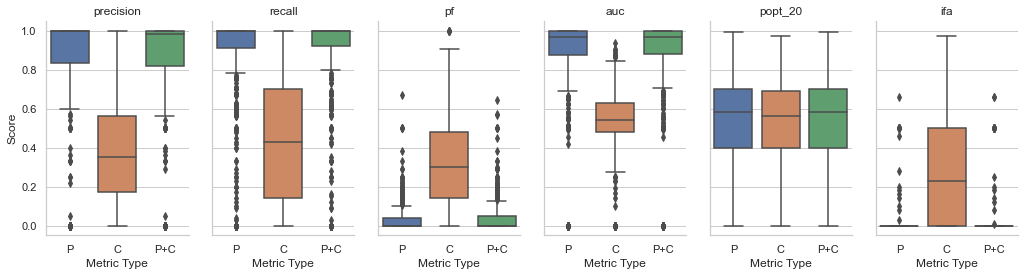

In [405]:
sns.set(style='whitegrid',font_scale=1)
order = ["P", "C", "P+C"]
g = sns.catplot(x="Metric Type", y="Score", col="Evaluation Criteria",height=4,aspect=0.6,margin_titles=True,kind="box", 
                order=order, data=final_df)
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.savefig('results/image/RF_release_dev_set3.pdf')

# compare stability across releases (RQ2)

In [469]:
count = 0
dfs = ['process','product','process+product']
orders = ["P", "C", "P+C"]
all_results = pd.DataFrame()
for k in range(len(dfs)):
    df = dfs[k]
    order = orders[k]
    result_df = pd.DataFrame()
    final_result = pd.read_pickle('results/Performance/commit_guru_file_specific/' + df +'_700_rf_release_devanvu_set3.pkl')
    for metric in final_result.keys():
        final_df = pd.DataFrame()
        release = [[],[],[]]
        for projects in final_result[metric].keys():
            if len(final_result[metric][projects]) < 3:
                continue
            count += 1
            i = 0
            for value in final_result[metric][projects]:
                if metric == 'ifa':
                    value = value/100
                release[i].append(value)
                i += 1
                if i == 3:
                    break
        for j in range(3):
            score_df = pd.DataFrame(release[j], columns = ['scores'])
            score_df['release'] = [j+1]*score_df.shape[0]
            final_df = pd.concat([final_df,score_df], axis = 0)
        final_df['metrics'] = [metric]*final_df.shape[0]
        result_df = pd.concat([result_df,final_df], axis = 0)
    result_df['Metric Type'] = [order]*result_df.shape[0]
    all_results = pd.concat([all_results,result_df])
all_results = all_results[all_results['metrics'] != 'featue_importance']


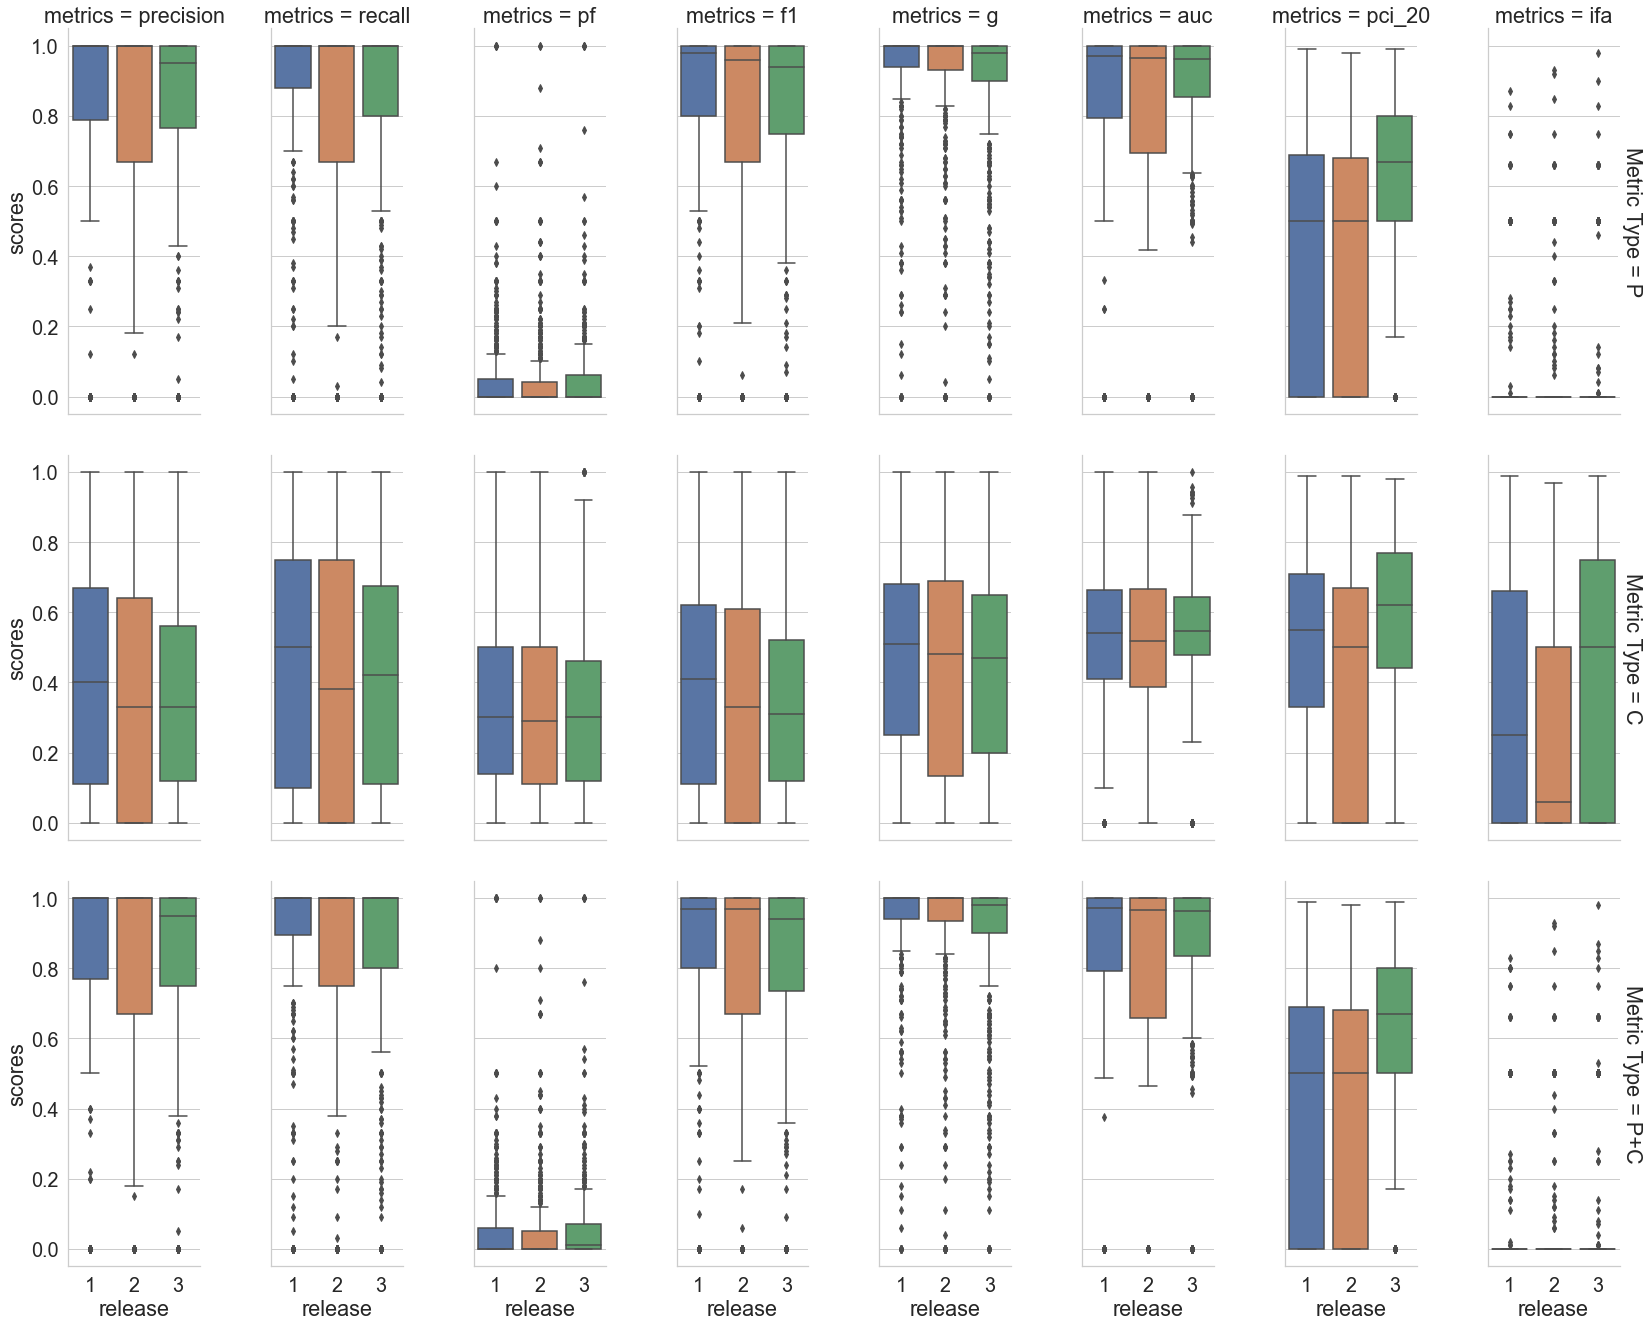

In [497]:
g = sns.set(style='whitegrid',font_scale=1.8)
order = [1,2,3]
g = sns.catplot(x="release", y="scores", col="metrics",row="Metric Type" ,height=4,aspect=0.6,margin_titles=True,kind="box", 
                order=order, data=all_results)
g.fig.set_figwidth(24)
g.fig.set_figheight(20)
g.savefig('results/image/RF_release_dev_set3.png')